### Importando os Pacotes Utilitários

In [1]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from distutils.dir_util import copy_tree
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import tarfile, os
import numpy as np
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Baixando os Conjuntos de Dados

In [3]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/CheXpert-v1.0-small.zip', 
                      extract_dir = '/content/CheXpert-v1.0-small', format = 'zip')

In [4]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/vinbigdata.zip', 
                      extract_dir = '/content/vinbigdata/', format = 'zip')

In [5]:
shutil.unpack_archive(filename = '/content/drive/MyDrive/datasets-lung-loc/images.zip', 
                      extract_dir = '/content/images/', format = 'zip')

### Organizando e Analisando os Dados

In [6]:
dataset = pd.read_csv('/content/all_datasets.csv', index_col = 0)
dataset = dataset[((dataset['Opacity'] == 1.0) | 
                   (dataset['Atelectasis'] == 1.0) | 
                   (dataset['Pneumothorax'] == 1.0) | 
                   (dataset['Effusion'] == 1.0)) & 
                   (dataset['Nodule/Mass'] == 0.0) &
                   (dataset['No Finding'] == 0.0)].copy()

dataset.drop(labels = 'Nodule/Mass', axis = 1, inplace = True)
dataset.drop(labels = 'No Finding', axis = 1, inplace = True)
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']

Text(0, 0.5, 'Imagens')

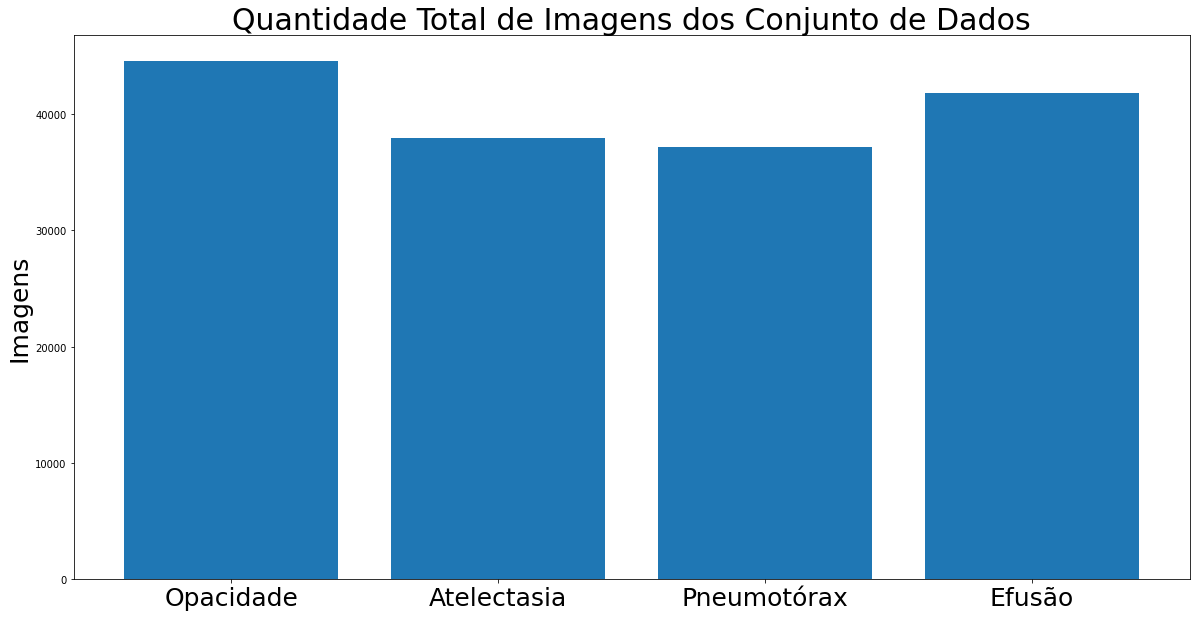

In [7]:
count_findings = list()
for finding in list(dataset.columns)[4:]:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(labels_portugues, count_findings)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

In [8]:
opacity = np.array(dataset['Opacity']).astype(str)
atelectasis = np.array(dataset['Atelectasis']).astype(str)
pneumothorax = np.array(dataset['Pneumothorax']).astype(str)
effusion = np.array(dataset['Effusion']).astype(str)

all_labels = np.zeros(effusion.shape).astype(str)
for index in range(0, len(opacity)):
  all_labels[index] = opacity[index] + atelectasis[index] + pneumothorax[index]
  all_labels[index] += effusion[index]

dataset['labels_ref'] = all_labels

In [9]:
f_train, f_val = train_test_split(dataset, test_size = 0.2, random_state = 42, 
                                  stratify = dataset['labels_ref'])
f_val, f_test = train_test_split(f_val, test_size = 0.5, random_state = 42, 
                                 stratify = f_val['labels_ref'])

f_train.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_val.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_test.drop(labels = ['labels_ref'], axis = 1, inplace = True)

Text(0, 0.5, 'Imagens')

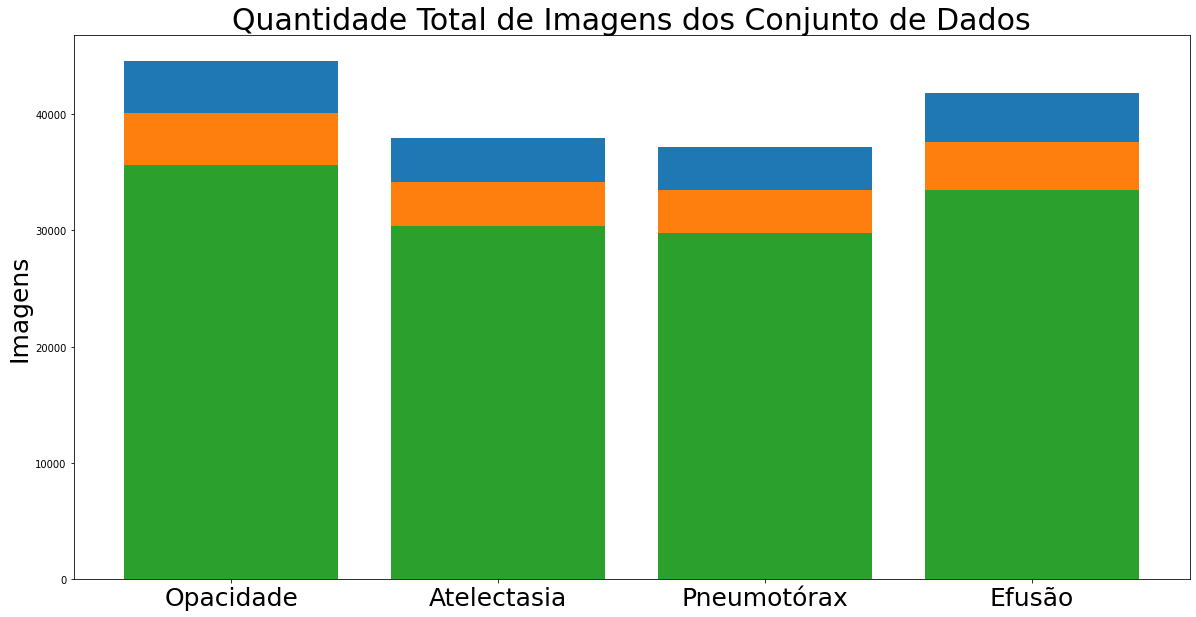

In [10]:
count_train, count_val, count_test = [], [], []
for finding in list(f_train.columns)[4:]:
  c_train = dict(f_train[finding].value_counts())[1.0]
  c_val = dict(f_val[finding].value_counts())[1.0]
  c_test = dict(f_test[finding].value_counts())[1.0]
  count_train.append(c_train), count_val.append(c_val), count_test.append(c_test)

plt.figure(figsize = (20, 10))
plt.bar(labels_portugues, np.sum((count_train, count_val, count_test), axis = 0))
plt.bar(labels_portugues, np.sum((count_train, count_val), axis = 0))
plt.bar(labels_portugues, count_train)
plt.xticks(rotation = 0, size = 25)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 25)

### Gerador de Imagens do Keras

In [11]:
image_size, batch_size = 224, 64

In [12]:
core_idg = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input, 
                              rotation_range = 3, width_shift_range = 0.05, 
                              height_shift_range = 0.05, fill_mode = 'constant')

train_gen = core_idg.flow_from_dataframe(dataframe = f_train, directory = None, 
                                         x_col = 'Path', y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size), 
                                         shuffle = True)

core_idg = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

valid_gen = core_idg.flow_from_dataframe(dataframe = f_val, directory = None, 
                                         x_col = 'Path',  y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size),
                                         shuffle = False)

test_gen = core_idg.flow_from_dataframe(dataframe = f_test, directory = None, 
                                        x_col = 'Path', y_col = labels, 
                                        class_mode = 'raw', batch_size = batch_size,
                                        target_size = (image_size, image_size),
                                        shuffle = False)

y_labels_valid = valid_gen.labels
y_labels_test = test_gen.labels

Found 70159 validated image filenames.
Found 8770 validated image filenames.
Found 8770 validated image filenames.


### Organizando uma Função Utilitária de Callback

In [ ]:
def get_callbacks(model_name, monitor = 'val_acc'):
    '''
    gerando uma lista de callbacks úteis para o treinamento da rede

    Args:
        model_name (str) --> nome do modelo em análise
        monitor (str) --> métrica de análise a ser monitorada pelo callback

    Returns:
        callbacks (list) --> Lista de callbacks
    '''
    checkpoint_file = f'model.{model_name}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_file,
                                                    verbose = 1, 
                                                    save_best_only = True, 
                                                    monitor = monitor, 
                                                    mode = 'max')
    
    return [checkpoint]

### Definindo uma Função de Congelamento de Camadas

In [ ]:
def freeze_layers(conv_base, layer_name):
  '''
  método de treinamento por congelamento de camadas das redes convolucionais

  Args:
    conv_base (tensor) --> camadas convolucionais do modelo
    layer_name (str) --> nome de referência da camada a ser iniciado o 
    congelamento
  '''

  conv_base.trainable = True
  set_trainable = False

  for layer in conv_base.layers:
    if layer.name == layer_name: set_trainable = True
    if set_trainable: layer.trainable = True
    else: layer.trainable = False
  
  return None

### Definindo uma Função de Binarização das Predições

In [17]:
def binarize_preds(pred_array, column, threshold):
  '''
  função que binariza as predições mutirrótulo do modelo

  Args:
    pred_array (array) --> vetor com as predições multirrótulo
    column (int) --> coluna do vetor multirrótulo a ser analisada
    threshold (float) --> valor de threshold a ser considerado na predição
  
  Returns:
    pred_bin (array) --> vetor de predição com os valores binarizados
  '''
  per_100 = pred_array[:,column] * 100
  pred_bin = list()
  for value in per_100:
    if value >= threshold: pred_bin.append(1)
    else: pred_bin.append(0)
  
  return pred_bin

### EfficientNetB0

In [ ]:
base_model = EfficientNetB0(include_top = False, weights = 'imagenet', 
                            input_shape = (image_size, image_size, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
efficientnet = tf.keras.Model(base_model.input, output)
efficientnet.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                     loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                     metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks(model_name = 'efficientnet', monitor = 'val_auc_3')

In [ ]:
layers_name = list()
for layer in base_model.layers:
  layers_name.append(layer.name)

block_names = ['block4a_dwconv_pad', 'block5c_project_conv', 'block7a_project_bn']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco block4a_dwconv_pad found!
Bloco block5c_project_conv found!
Bloco block7a_project_bn found!


In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[2])
efficientnet.fit(train_gen, validation_data = valid_gen, epochs = 5, 
                 callbacks = callbacks, use_multiprocessing = True, 
                 workers = 8)

Epoch 1/5
1097/1097 [==============================] - ETA: 0s - loss: 0.5340 - auc_3: 0.7946
Epoch 1: val_auc_3 improved from -inf to 0.80787, saving model to model.efficientnet.h5
1097/1097 [==============================] - 562s 500ms/step - loss: 0.5340 - auc_3: 0.7946 - val_loss: 0.5310 - val_auc_3: 0.8079
Epoch 2/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4888 - auc_3: 0.8317
Epoch 2: val_auc_3 improved from 0.80787 to 0.81098, saving model to model.efficientnet.h5
1097/1097 [==============================] - 533s 482ms/step - loss: 0.4888 - auc_3: 0.8317 - val_loss: 0.5393 - val_auc_3: 0.8110
Epoch 3/5
1097/1097 [==============================] - ETA: 0s - loss: 0.4663 - auc_3: 0.8486
Epoch 3: val_auc_3 improved from 0.81098 to 0.81168, saving model to model.efficientnet.h5
1097/1097 [==============================] - 533s 482ms/step - loss: 0.4663 - auc_3: 0.8486 - val_loss: 0.5689 - val_auc_3: 0.8117
Epoch 4/5
1097/1097 [==============================] - 

In [ ]:
efficientnet.load_weights('/content/model.efficientnet.h5')
efficientnet.save('model_efficientnet1')
shutil.make_archive(base_name = 'model_efficientnet1', format = 'zip', 
                    root_dir = '/content/model_efficientnet1')
shutil.move('/content/model_efficientnet1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/EfficientNetB0')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[1])
efficientnet.fit(train_gen, validation_data = valid_gen, epochs = 5, 
                 callbacks = callbacks, use_multiprocessing = True, 
                 workers = 8)

Epoch 1/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3995 - auc_3: 0.8911
Epoch 1: val_auc_3 improved from 0.82337 to 0.85819, saving model to model.efficientnet.h5
1097/1097 [==============================] - 531s 480ms/step - loss: 0.3995 - auc_3: 0.8911 - val_loss: 0.4667 - val_auc_3: 0.8582
Epoch 2/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3749 - auc_3: 0.9046
Epoch 2: val_auc_3 improved from 0.85819 to 0.86628, saving model to model.efficientnet.h5
1097/1097 [==============================] - 529s 479ms/step - loss: 0.3749 - auc_3: 0.9046 - val_loss: 0.4579 - val_auc_3: 0.8663
Epoch 3/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3500 - auc_3: 0.9173
Epoch 3: val_auc_3 did not improve from 0.86628
1097/1097 [==============================] - 526s 476ms/step - loss: 0.3500 - auc_3: 0.9173 - val_loss: 0.5056 - val_auc_3: 0.8635
Epoch 4/5
1097/1097 [==============================] - ETA: 0s - loss: 0.3270 - auc_3: 0.9282
E

In [ ]:
efficientnet.load_weights('/content/model.efficientnet.h5')
efficientnet.save('model_efficientnet2')
shutil.make_archive(base_name = 'model_efficientnet2', format = 'zip', 
                    root_dir = '/content/model_efficientnet2')
shutil.move('/content/model_efficientnet2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/EfficientNetB0')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[0])
efficientnet.fit(train_gen, validation_data = valid_gen, epochs = 5, 
                 callbacks = callbacks, use_multiprocessing = True, 
                 workers = 8)

Epoch 1/5
1097/1097 [==============================] - ETA: 0s - loss: 0.2879 - auc_3: 0.9442
Epoch 1: val_auc_3 improved from 0.88174 to 0.88289, saving model to model.efficientnet.h5
1097/1097 [==============================] - 536s 485ms/step - loss: 0.2879 - auc_3: 0.9442 - val_loss: 0.4559 - val_auc_3: 0.8829
Epoch 2/5
1097/1097 [==============================] - ETA: 0s - loss: 0.2685 - auc_3: 0.9516
Epoch 2: val_auc_3 did not improve from 0.88289
1097/1097 [==============================] - 533s 482ms/step - loss: 0.2685 - auc_3: 0.9516 - val_loss: 0.5642 - val_auc_3: 0.8725
Epoch 3/5
1097/1097 [==============================] - ETA: 0s - loss: 0.2515 - auc_3: 0.9575
Epoch 3: val_auc_3 improved from 0.88289 to 0.89385, saving model to model.efficientnet.h5
1097/1097 [==============================] - 533s 482ms/step - loss: 0.2515 - auc_3: 0.9575 - val_loss: 0.4575 - val_auc_3: 0.8939
Epoch 4/5
1097/1097 [==============================] - ETA: 0s - loss: 0.2379 - auc_3: 0.9620
E

In [ ]:
efficientnet.load_weights('/content/model.efficientnet.h5')
efficientnet.save('model_efficientnet3')
shutil.make_archive(base_name = 'model_efficientnet3', format = 'zip', 
                    root_dir = '/content/model_efficientnet3')
shutil.move('/content/model_efficientnet3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/EfficientNetB0')

In [ ]:
shutil.move('/content/model.efficientnet.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification/EfficientNetB0')

In [14]:
y_pred_val = efficientnet.predict(valid_gen)
y_pred = efficientnet.predict(test_gen)
print(f'AUC | Dados de Validação = {efficientnet.evaluate(valid_gen)[1] * 100} %')
print(f'AUC | Dados de Teste = {efficientnet.evaluate(test_gen)[1] * 100} %')

138/138 [==============================] - 50s 333ms/step - loss: 0.4575 - auc_3: 0.8939
AUC | Dados de Validação = 89.38513398170471 %
138/138 [==============================] - 47s 341ms/step - loss: 0.4378 - auc_3: 0.8980
AUC | Dados de Teste = 89.80462551116943 %


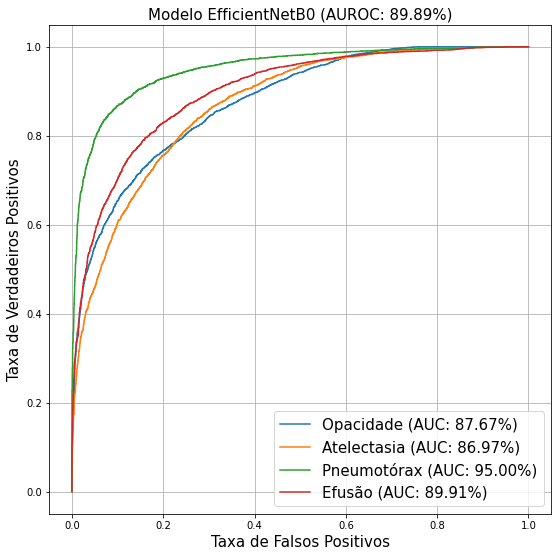

In [15]:
labels_portugues = ['Opacidade', 'Atelectasia', 'Pneumotórax', 'Efusão']
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(y_labels_test[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
auroc_value = str(roc_auc_score(y_labels_test.astype(int), y_pred)*100)[0:5]
c_ax.set_title('Modelo EfficientNetB0 (AUROC: ' + auroc_value + '%)', size = 15)
c_ax.grid(True)

In [18]:
threshold_variation = dict()
for label_index in range(0, len(labels)):
  threshold_variation[label_index] = list()
  for threshold in range(1, 100):
    y_pred_bin = binarize_preds(pred_array = y_pred_val, column = label_index, 
                                threshold = threshold)
    matrix = confusion_matrix(y_labels_valid[:, label_index], y_pred_bin)
    acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
    threshold_variation[label_index].append(acc)

bests_thresholds = list()
for label_index in range(0, len(labels)):
   for threshold in range(1, 100):
     if threshold_variation[label_index][threshold] == np.max(threshold_variation[label_index]):
       bests_thresholds.append(threshold)
       break

In [19]:
for label_index in range(0,len(labels)):
  y_pred_bin = binarize_preds(pred_array = y_pred, column = label_index, 
                              threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(y_labels_test[:, label_index], y_pred_bin)
  acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
  precision = matrix[0,0]/(matrix[0,0]+matrix[0,1])
  recall = matrix[0,0]/(matrix[0,0]+matrix[1,0])
  f1_score = (2*precision*recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc*100} % | Precisão = {precision*100} % | '
        f'\nSensibilidade = {recall*100} % | F1 Score = {f1_score*100} %\n')

==Opacidade== 
[[3583  729]
 [1160 3298]], Threshold = 58
Acurácia = 78.460661345496 % | Precisão = 83.09369202226345 % | 
Sensibilidade = 75.54290533417668 % | F1 Score = 79.13859745996686 %

==Atelectasia== 
[[3855 1115]
 [ 824 2976]], Threshold = 46
Acurácia = 77.89053591790194 % | Precisão = 77.56539235412475 % | 
Sensibilidade = 82.3893994443257 % | F1 Score = 79.90465333195151 %

==Pneumotórax== 
[[4677  375]
 [ 600 3118]], Threshold = 72
Acurácia = 88.88255416191562 % | Precisão = 92.57719714964371 % | 
Sensibilidade = 88.62990335417851 % | F1 Score = 90.5605576532094 %

==Efusão== 
[[3961  629]
 [ 975 3205]], Threshold = 73
Acurácia = 81.71037628278222 % | Precisão = 86.29629629629629 % | 
Sensibilidade = 80.24716369529983 % | F1 Score = 83.16187276926307 %

